<a href="https://colab.research.google.com/github/mgdixon/text2mol-team29/blob/main/DL4H_Team_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS598: DLH - Final Submission

### Team 29
* Antony Vo (avvo3@illinois.edu),
* Anirudh Prasad (ap73@illinois.edu),
* Martin Dixon (mgdixon2@illinois.edu)

### Date: May 5th, 2024

Team Github Page: https://github.com/mgdixon/text2mol-team29

Video presentation: **TODO** URL

# Introduction

This work presented below is in cross-modal molecule retrieval. That is, the mapping of chemical descriptions to molecular graphs. Solving this problem has a lot of benefits namely:

* Improving molecule discovery and design
* Facilitating semantic-level search between natural language and molecules
* Enabling natural language query expansion in chemistry information retrieval systems

Text2Mol [1] develops a new cross-modal information retrieval task, where molecules are retrieved directly from natural language descriptions.

E.g. A description of water (chemical formula being H20) as 2x Hydrogen Atoms bonded to an Oxygen should return a molecular graph.  The task is considered to be a cross-lingual information retrieval problem (CLIR).  Unlike other CLIR problems, the Text2Mol task involves bridging English and the language of molecules.  As a result, this task is more challenging than traditional CLIR approaches due to the large gap between the query and the target.  Molecules are treated as a different language with a particularly challenging grammar requiring various specialized techniques.

The Text2Mol task is a novel task and has no exact prior state of the art work.  However, various existing techniques are combined including SciBERT [2] and Mol2Vec [3].  Similar work does exist in cross-lingual information retrieval, but this work typically involves translating the query into the target language or vice versa. (Zhang and Zhao, 2020) [6] Additional work exists in using interlingual semantics such as bilingual word embeddings (Vulic and Moens, 2015) [7] and word embeddings with a dictionary (Bhattacharya et al., 2016) [8].


The authors develop a cross-modal embedding approach using a text encoder (e.g., SciBERT) and a molecule encoder (e.g., GCN and MLP) to create aligned semantic representations. The system uses cosine similarity for ranking molecules and leverages cross-modal attention to extract interpretable associations between text and molecule substructures. Overall the paper demonstrates the effectiveness of an ensemble approach that combines different molecule encoder architectures.

The innovations of the paper include the new task described above along with a demonstration of results from various off-the-shelf techniques.  The paper also demonstrates how to use cross-modal attention-based association rules to improve results and explainability in a text-molecule information retrieval task.  Finally, the paper introduces a new dataset to be utilized for future innovations in this domain.  The paper contributes to the research regime mainly by defining a new task and area for active research.

The results of the paper are promising with around 22% for Hits@1 and 68% for Hits@10 for individual molecule embedding approaches such as MLP and GCN.  Utilizing ensembles raises Hits@1 to 34% and Hits@10 to 81%.  Future research on this new task will likely raise the hit rates.

The majority of the code below was taken and modified from the [GitHub](https://github.com/cnedwards/text2mol/tree/master/code) repository under the [MIT License](https://opensource.org/license/mit).



# Scope of Reproducibility

Hypotheses to be tested:

* The MLP and GCN approaches for molecule encoding give roughly similar retrieval performance (Hits@1, Hits@10).
* Each version of MLP (MLP 1-3) and GCN (GCN 1-3) have similar retrieval performance (Hits@1, Hits@10).
* Using either MLP or GCN approaches can retrieve the correct molecule within the first 10 hits most of the time (Hits@10).
* Using ensembles of different molecule encoder architectures improves retrieval metrics over using individual architectures.
* Using more models in the ensembles improves performance over using less models in the ensembles.

Experiments:

* Run MLP approach
* Run GCN approach
* Run ensembles of the above models





# Methodology

Below is our methodology for reproducing Text2Mol. We start with prerequisites. That is, libraries, imports, constants, etc. We then download our pretrained models and our data from Google Cloud Storage.

## Libraries, Imports and Setup

### Environment

The Python version we used for development was: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

The requirements.txt for our notebook is at https://github.com/mgdixon/text2mol-team29/blob/main/requirements.txt.

The only additional install we apply is torch-geometric.  

In [1]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:00


In [2]:
# import necessary packages
import numpy as np
from google.colab import drive

# Text2Mol Imports
import os
import shutil
import time
import random
import csv
import math
import os.path as osp
import zipfile

from functools import partial

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Torch Libraries
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

# Tokenizer
import tokenizers
from tokenizers import Tokenizer

# Bert Model
from transformers import BertTokenizerFast, BertModel


In [3]:
# Torch Geometric - used by GCN
from torch_geometric.data import download_url, Data
from torch_geometric.data import Dataset as GeoDataset
from torch_geometric.data import DataLoader as GeoDataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

### Constants

The constants below are used by Text2Mol. For clarity, pulling them upfront in the notebook for visibility.

In [4]:
# dir and function to load raw data
RAW_DATA_DIR = 'text2mol-master/data/'

# model filenames
GCN_MODEL_PATH = 'GCN_final_weights.40.pt'
MLP_MODEL_PATH = 'MLP_final_weights.40.pt'
TRANSFORMER_MODEL_PATH = 'transformer_final_weights.40.pt'

# Constants for training
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_WORKERS = 1
TEXT_TRUNC_LENGTH = 256

# For the purpose of this file, we only run 2 Epochs
NUM_EPOCHS = 2

# Reduce the training set size to demonstrate training in a timely manner
FACTOR_TO_REDUCE_TRAINING_SET = 0.10

# Flags to determine if we train the 3x models
TRAIN_MLP = True
TRAIN_GCN = True
TRAIN_TRANSFORMER = True

# Flag to reduce the ensemble model
ENSEMBLE_FULL = True


### Fetch Data from GCS

Our group decided to store the files on GCS and utilize the local colab filesystem for everything else. This seemed faster than Google Drive, as there is one file `mol_graph.zip` that consists of thousands of tiny text files. These perform very badly with remote filesystem overhead. Additionally, we wished to avoid having to authenticate to access files. Instead we download everything to the local disk for speed.

In [5]:
# The original github repo
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/text2mol-master.zip
!unzip -o -q text2mol-master.zip

# The trained MLP, GCN and transformer models from 40 epochs each
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/MLP_final_weights.40.pt
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/GCN_final_weights.40.pt
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/transformer_final_weights.40.pt

# The multi-head attention weights from the transformer model
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/mha_weights.pkl

# Fetch the embeddings & untar
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/GCN_embeddings.tar.gz
!mkdir GCN_embeddings
!cd GCN_embeddings && tar xfz ../GCN_embeddings.tar.gz

!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/MLP_embeddings.tar.gz
!mkdir MLP_embeddings
!cd MLP_embeddings && tar xfz ../MLP_embeddings.tar.gz

# Fetch the second and third trained models & untar for the ensemble
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/GCN2_embeddings.tar.xz
!mkdir GCN2_embeddings
!cd GCN2_embeddings && xzcat ../GCN2_embeddings.tar.xz | tar xf -

!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/GCN3_embeddings.tar.xz
!mkdir GCN3_embeddings
!cd GCN3_embeddings && xzcat ../GCN3_embeddings.tar.xz | tar xf -

!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/MLP2_embeddings.tar.xz
!mkdir MLP2_embeddings
!cd MLP2_embeddings && xzcat ../MLP2_embeddings.tar.xz | tar xf -

!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/MLP3_embeddings.tar.xz
!mkdir MLP3_embeddings
!cd MLP3_embeddings && xzcat ../MLP3_embeddings.tar.xz | tar xf -


2024-05-03 03:19:42 URL:https://storage.googleapis.com/team29-text2mol/text2mol-master.zip [132874985/132874985] -> "text2mol-master.zip" [1]
2024-05-03 03:19:48 URL:https://storage.googleapis.com/team29-text2mol/models/MLP_final_weights.40.pt [443581922/443581922] -> "MLP_final_weights.40.pt" [1]
2024-05-03 03:20:23 URL:https://storage.googleapis.com/team29-text2mol/models/GCN_final_weights.40.pt [447911244/447911244] -> "GCN_final_weights.40.pt" [1]
2024-05-03 03:20:27 URL:https://storage.googleapis.com/team29-text2mol/models/transformer_final_weights.40.pt [516032390/516032390] -> "transformer_final_weights.40.pt" [1]
2024-05-03 03:20:32 URL:https://storage.googleapis.com/team29-text2mol/models/mha_weights.pkl [471199638/471199638] -> "mha_weights.pkl" [1]
2024-05-03 03:20:33 URL:https://storage.googleapis.com/team29-text2mol/models/GCN_embeddings.tar.gz [73596622/73596622] -> "GCN_embeddings.tar.gz" [1]
2024-05-03 03:20:35 URL:https://storage.googleapis.com/team29-text2mol/models/M

## Data

The data used in Text2Mol was created by the authors by utilizing ChEBI (Chemical Entities of Biological Interest) [9] and PubChem [10]. This was done by initially gathering 102,980 compound-description pairs from chemical annotations. The "ChEBI-20" dataset, which contains more than 20 words in its descriptions, was then produced from this data with 33,010 pairs. Text2Mol uses this dataset for training, validation, and testing in an **80%/10%/10% split** respectively.

The data is available on [GitHub](https://github.com/cnedwards/text2mol/tree/master/data).




---


**Data generation**

There are two data generators used in the project. The first one is used for the MLP and GCN models. The second is used for the Attention model. The Attention flavor differs by the use of a coin toss to set whether the actual description is used or a random one. The authors duplicated code heavily in their notebooks which can make it hard to read.

In [6]:
class GenerateData():
  def __init__(self, path_train, path_val, path_test, path_molecules, path_token_embs):
    self.path_train = path_train
    self.path_val = path_val
    self.path_test = path_test
    self.path_molecules = path_molecules
    self.path_token_embs = path_token_embs

    self.text_trunc_length = TEXT_TRUNC_LENGTH

    self.prep_text_tokenizer()

    self.load_substructures()

    self.batch_size = BATCH_SIZE

    self.store_descriptions()

  def load_substructures(self):
    self.molecule_sentences = {}
    self.molecule_tokens = {}

    total_tokens = set()
    self.max_mol_length = 0
    with open(self.path_molecules) as f:
      for line in f:
        spl = line.split(":")
        cid = spl[0]
        tokens = spl[1].strip()
        self.molecule_sentences[cid] = tokens
        t = tokens.split()
        total_tokens.update(t)
        size = len(t)
        if size > self.max_mol_length: self.max_mol_length = size

    self.token_embs = np.load(self.path_token_embs, allow_pickle = True)[()]


  def prep_text_tokenizer(self):
    self.text_tokenizer = BertTokenizerFast.from_pretrained("allenai/scibert_scivocab_uncased")

  # Refactored version that's much shorter
  def read_file(self, file_path):
    cids = []
    with open(file_path) as f:
        reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE,
                                fieldnames=['cid', 'mol2vec', 'desc'])
        for line in reader:
            self.descriptions[line['cid']] = line['desc']
            self.mols[line['cid']] = line['mol2vec']
            cids.append(line['cid'])
    return cids

  def store_descriptions(self):
    self.descriptions = {}
    self.mols = {}
    self.training_cids = self.read_file(self.path_train)
    self.validation_cids = self.read_file(self.path_val)
    self.test_cids = self.read_file(self.path_test)

  # Refactored version
  def generate_examples(self, cids):
    """Yields examples."""

    np.random.shuffle(cids)

    for cid in cids:
      text_input = self.text_tokenizer(self.descriptions[cid], truncation=True,
                                       max_length=self.text_trunc_length,
                                        padding='max_length', return_tensors = 'np')

      yield {
          'cid': cid,
          'input': {
              'text': {
                'input_ids': text_input['input_ids'].squeeze(),
                'attention_mask': text_input['attention_mask'].squeeze(),
                'original_text': self.descriptions[cid]
              },
              'molecule' : {
                    'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
                    'cid' : cid
              },
          },
      }

  def generate_examples_train(self):
    yield from self.generate_examples(self.training_cids)

  def generate_examples_val(self):
    yield from self.generate_examples(self.validation_cids)

  def generate_examples_test(self):
    yield from self.generate_examples(self.test_cids)

  def generate_examples_custom(self, custom_cids):
    yield from self.generate_examples(custom_cids)



---

**The Attention model Generator**

This is a slightly different generator used by the Attention model. As mentioned above, it uses a coin toss to decide which text description is used.

In [7]:
class GenerateDataAttention():
  def __init__(self, path_train, path_val, path_test, path_molecules,
               path_token_embs):
    self.path_train = path_train
    self.path_val = path_val
    self.path_test = path_test
    self.path_molecules = path_molecules
    self.path_token_embs = path_token_embs

    self.mol_trunc_length = 512
    self.text_trunc_length = 256

    self.prep_text_tokenizer()

    self.load_substructures()

    self.batch_size = BATCH_SIZE

    self.store_descriptions()

  def load_substructures(self):
    self.molecule_sentences = {}
    self.molecule_tokens = {}

    total_tokens = set()
    self.max_mol_length = 0
    with open(self.path_molecules) as f:
      for line in f:
        spl = line.split(":")
        cid = spl[0]
        tokens = spl[1].strip()
        self.molecule_sentences[cid] = tokens
        t = tokens.split()
        total_tokens.update(t)
        size = len(t)
        if size > self.max_mol_length: self.max_mol_length = size


    self.token_embs = np.load(self.path_token_embs, allow_pickle = True)[()]



  def prep_text_tokenizer(self):
    self.text_tokenizer = BertTokenizerFast.from_pretrained("allenai/scibert_scivocab_uncased")


  # Refactored version that's much shorter
  def read_file(self, file_path):
    cids = []
    with open(file_path) as f:
        reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE,
                                fieldnames=['cid', 'mol2vec', 'desc'])
        for line in reader:
            self.descriptions[line['cid']] = line['desc']
            self.mols[line['cid']] = line['mol2vec']
            cids.append(line['cid'])
    return cids

  def store_descriptions(self):
    self.descriptions = {}
    self.mols = {}
    self.training_cids = self.read_file(self.path_train)
    self.validation_cids = self.read_file(self.path_val)
    self.test_cids = self.read_file(self.path_test)

  #transformers can't take array with full attention so have to pad a 0...
  def padarray(self, A, size, value=0):
      t = size - len(A)
      return np.pad(A, pad_width=(0, t), mode='constant',
                    constant_values = value)

  def generate_examples(self, cids):
    """Yields examples."""

    np.random.shuffle(cids)

    for cid in cids:
        label = np.random.randint(2)
        rand_cid = np.random.choice(cids)

        # Choose description based on label
        if label:
            description = self.descriptions[cid]
        else:
            description = self.descriptions[rand_cid]

        text_input = self.text_tokenizer(description, truncation=True,
                                         max_length=self.text_trunc_length - 1,
                                         padding='max_length', return_tensors='np')

        text_ids = self.padarray(text_input['input_ids'].squeeze(), self.text_trunc_length)
        text_mask = self.padarray(text_input['attention_mask'].squeeze(), self.text_trunc_length)

        yield {
            'cid': cid,
            'input': {
                'text': {
                    'input_ids': text_ids,
                    'attention_mask': text_mask,
                },
                'molecule': {
                    'mol2vec': np.fromstring(self.mols[cid], sep=" "),
                    'cid': cid
                },
            },
            'label': label
        }


  def generate_examples_train(self):
    return self.generate_examples(self.training_cids)

  def generate_examples_val(self):
    return self.generate_examples(self.validation_cids)

  def generate_examples_test(self):
    return self.generate_examples(self.test_cids)

  def generate_examples_custom(self, custom_cids):
    yield from self.generate_examples(custom_cids)




---

**Graph Dataset**

This code creates a custom graph Dataset & Dataloader for the chemical ids extracted from the file `mol_graph.zip`.

In [8]:

class MoleculeGraphDataset(GeoDataset):
    def __init__(self, root, cids, data_path, gt, transform=None,
                 pre_transform=None):
        self.cids = cids
        self.data_path = data_path
        self.gt = gt
        super(MoleculeGraphDataset, self).__init__(root, transform,
                                                   pre_transform)

        self.idx_to_cid = {}
        i = 0
        for raw_path in self.raw_paths:
            cid = int(raw_path.split('/')[-1][:-6])
            self.idx_to_cid[i] = cid
            i += 1

    @property
    def raw_file_names(self):
        return [cid + ".graph" for cid in self.cids]

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(cid) for cid in self.cids]

    def download(self):
        # Download to `self.raw_dir`.
        shutil.copy(self.data_path, os.path.join(self.raw_dir,
                                                 "/mol_graphs.zip"))

    def process_graph(self, raw_path):
      edge_index  = []
      x = []
      with open(raw_path, 'r') as f:
        next(f)
        for line in f: #edges
          if line != "\n":
            edge = *map(int, line.split()),
            edge_index.append(edge)
          else:
            break
        next(f)
        for line in f: #get mol2vec features:
          substruct_id = line.strip().split()[-1]
          if substruct_id in self.gt.token_embs:
            x.append(self.gt.token_embs[substruct_id])
          else:
            x.append(self.gt.token_embs['UNK'])

        return torch.LongTensor(edge_index).T, torch.FloatTensor(x)



    def process(self):

        with zipfile.ZipFile(os.path.join(self.raw_dir, "/mol_graphs.zip"),
                             'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)


        i = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.

            cid = int(raw_path.split('/')[-1][:-6])

            edge_index, x = self.process_graph(raw_path)
            data = Data(x=x, edge_index = edge_index)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir,
                                      'data_{}.pt'.format(cid)))
            i += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir,
                                   'data_{}.pt'.format(self.idx_to_cid[idx])))
        return data

    def get_cid(self, cid):
        data = torch.load(osp.join(self.processed_dir,
                                   'data_{}.pt'.format(cid)))
        return data

#To get specific lists...

class CustomGraphCollater(object):
    def __init__(self, dataset, follow_batch = [], exclude_keys = []):
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys
        self.dataset = dataset

    def collate(self, batch):
        elem = batch[0]
        if isinstance(elem, Data):
            return Batch.from_data_list(batch)

        raise TypeError('DataLoader found invalid type: {}'.format(type(elem)))

    def __call__(self, cids):

        return self.collate([self.dataset.get_cid(int(cid)) for cid in cids])

class CustomGraphCollaterTransformer(object):
    def __init__(self, dataset, mask_len, follow_batch = [], exclude_keys = []):
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys
        self.dataset = dataset
        self.mask_len = mask_len
        self.mask_indices = np.array(range(mask_len))

    def generate_mask(self, sz):
        rv = torch.zeros((self.mask_len), dtype = torch.bool)
        rv = rv.masked_fill(torch.BoolTensor(self.mask_indices < sz), bool(1))
        rv[-1] = 0 #set last value to 0 because pytorch can't handle all 1s
        return rv

    def get_masks(self, batch):
      return torch.stack([self.generate_mask(b.x.shape[0]) for b in batch])

    def collate(self, batch):
        elem = batch[0]
        if isinstance(elem, Data):
            return Batch.from_data_list(batch)

        raise TypeError('DataLoader found invalid type: {}'.format(type(elem)))

    def __call__(self, cids):

        tmp = [self.dataset.get_cid(int(cid)) for cid in cids]
        return self.collate(tmp), self.get_masks(tmp)

In [9]:
class Dataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, gen, length):
      'Initialization'

      self.gen = gen
      self.it = iter(self.gen())

      self.length = length

  def __len__(self):
      'Denotes the total number of samples'
      return self.length


  def __getitem__(self, index):
      'Generates one sample of data'

      try:
        ex = next(self.it)
      except StopIteration:
        self.it = iter(self.gen())
        ex = next(self.it)

      X = ex['input']
      y = 1

      return X, y

---

**Loading & Processing Data**

Below we load and process the molecules and the graph data. This code takes several minutes to run. Afterwards we show some statistics on the loaded dataset.

In [10]:
def load_raw_data(raw_data_dir):
  # implement this function to load raw data to dataframe/numpy array/tensor
  mounted_path_token_embs = raw_data_dir + 'token_embedding_dict.npy'
  mounted_path_train = raw_data_dir + 'training.txt'
  mounted_path_val = raw_data_dir + 'val.txt'
  mounted_path_test = raw_data_dir + 'test.txt'
  mounted_path_molecules = raw_data_dir + 'ChEBI_defintions_substructure_corpus.cp'

  data_generator = GenerateData(mounted_path_train, mounted_path_val,
                                mounted_path_test, mounted_path_molecules,
                                mounted_path_token_embs)
  transformer_data_generator =  GenerateDataAttention(mounted_path_train,
                                                      mounted_path_val,
                                                      mounted_path_test,
                                                      mounted_path_molecules,
                                                      mounted_path_token_embs)

  return data_generator, transformer_data_generator

def load_processed_data(data_generator, factor_to_reduce_training_set=None):
  if factor_to_reduce_training_set is None:
    training_set = Dataset(data_generator.generate_examples_train,
                           len(data_generator.training_cids))
  else:
    reduced_training_cids = data_generator.training_cids[:int(factor_to_reduce_training_set * len(data_generator.training_cids))]
    training_set = Dataset(partial(data_generator.generate_examples_custom, reduced_training_cids), len(reduced_training_cids))

  validation_set = Dataset(data_generator.generate_examples_val,
                           len(data_generator.validation_cids))
  test_set = Dataset(data_generator.generate_examples_test,
                     len(data_generator.test_cids))

  return training_set, validation_set, test_set

def load_molecule_graph(raw_data_dir, data_generator, factor_to_reduce_training_set=None):
  root = 'graph-data/'
  graph_data_path = raw_data_dir + "mol_graphs.zip"

  if factor_to_reduce_training_set is None:
    mg_data_tr = MoleculeGraphDataset(root, data_generator.training_cids,
                                      graph_data_path, data_generator)
  else:
    reduced_training_cids = data_generator.training_cids[:int(factor_to_reduce_training_set * len(data_generator.training_cids))]
    mg_data_tr = MoleculeGraphDataset(root, reduced_training_cids,
                                      graph_data_path, data_generator)

  graph_batcher_tr = CustomGraphCollater(mg_data_tr)
  transformer_graph_batcher_tr = CustomGraphCollaterTransformer(mg_data_tr, transformer_data_generator.mol_trunc_length)

  mg_data_val = MoleculeGraphDataset(root, data_generator.validation_cids,
                                     graph_data_path, data_generator)
  graph_batcher_val = CustomGraphCollater(mg_data_val)
  transformer_graph_batcher_val = CustomGraphCollaterTransformer(mg_data_val, transformer_data_generator.mol_trunc_length)

  mg_data_test = MoleculeGraphDataset(root, data_generator.test_cids,
                                      graph_data_path, data_generator)
  graph_batcher_test = CustomGraphCollater(mg_data_test)
  transformer_graph_batcher_test = CustomGraphCollaterTransformer(mg_data_test, transformer_data_generator.mol_trunc_length)


  return mg_data_tr, mg_data_val, mg_data_test, graph_batcher_tr, graph_batcher_val, graph_batcher_test, transformer_graph_batcher_tr, transformer_graph_batcher_val, transformer_graph_batcher_test


data_generator, transformer_data_generator = load_raw_data(RAW_DATA_DIR)

mg_data_tr, mg_data_val, mg_data_test, \
graph_batcher_tr, graph_batcher_val, graph_batcher_test, \
transformer_graph_batcher_tr, transformer_graph_batcher_val, transformer_graph_batcher_test =\
  load_molecule_graph(RAW_DATA_DIR, data_generator, FACTOR_TO_REDUCE_TRAINING_SET)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Processing...
<ipython-input-8-2410893676a1>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.LongTensor(edge_index).T, torch.FloatTensor(x)
<ipython-input-8-2410893676a1>:49: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  return torch.LongTensor(edge_index).T, torch.FloatTensor(x)
Done!
Processing...
Done!
Processing...
Done!


Train size: 26408
Validation size: 3301
Test size: 3301
Total number of molecules: 33010


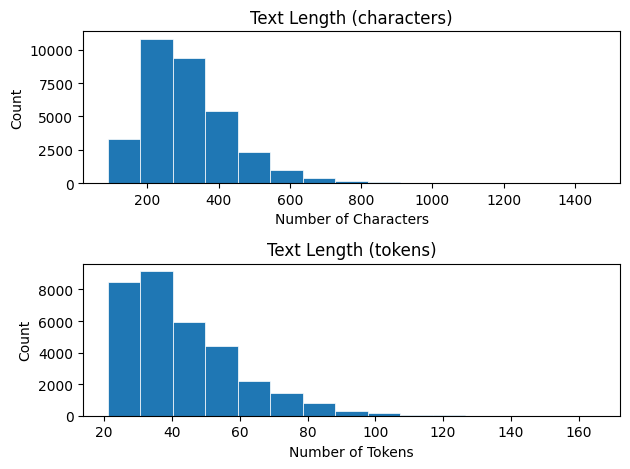

In [11]:
# calculate statistics
def calculate_stats(data_generator):
  # implement this function to calculate the statistics
  # it is encouraged to print out the results

  train_data_for_stats = list(data_generator.generate_examples_train())
  val_data_for_stats = list(data_generator.generate_examples_val())
  test_data_for_stats = list(data_generator.generate_examples_test())
  print(f'Train size: {len(train_data_for_stats)}')
  print(f'Validation size: {len(val_data_for_stats)}')
  print(f'Test size: {len(test_data_for_stats)}')

  all_data_for_stats = train_data_for_stats + val_data_for_stats + test_data_for_stats
  print(f'Total number of molecules: {len(all_data_for_stats)}')

  description_lengths_chars = [len(data['input']['text']['original_text']) for data in all_data_for_stats]

  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
  ax1.hist(description_lengths_chars, bins=15, linewidth=0.5, edgecolor="white")
  ax1.set_xlabel('Number of Characters')
  ax1.set_ylabel('Count')
  ax1.set_title('Text Length (characters)')

  description_lengths_tokens = [len(data['input']['text']['original_text'].split()) for data in all_data_for_stats]
  ax2.hist(description_lengths_tokens, bins=15, linewidth=0.5, edgecolor="white")
  ax2.set_xlabel('Number of Tokens')
  ax2.set_ylabel('Count')
  ax2.set_title('Text Length (tokens)')

  plt.tight_layout()
  plt.show()

  return all_data_for_stats

all_data_for_stats = calculate_stats(data_generator)




Processing...
Done!


Number of node features: 300
Is directed: False


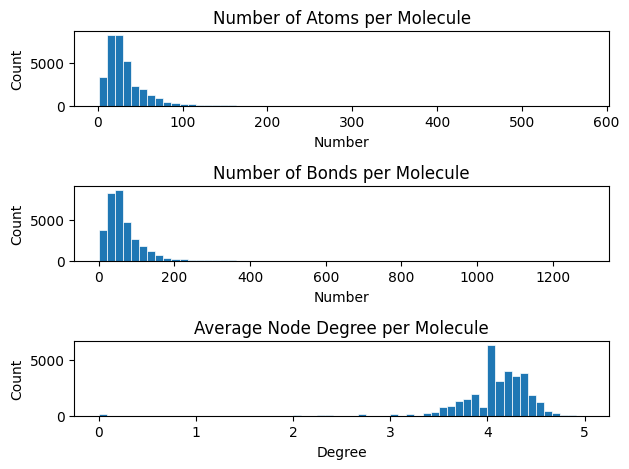

In [12]:
def calculate_molecule_graph_stats(raw_data_dir, data_generator):
  root = 'graph-data/'
  graph_data_path = raw_data_dir + "mol_graphs.zip"

  all_cids = data_generator.training_cids + data_generator.validation_cids + \
    data_generator.test_cids
  mg_data_all = MoleculeGraphDataset(root, all_cids, graph_data_path, data_generator)

  print(f'Number of node features: {mg_data_all.get(0).num_features}')
  print(f'Is directed: {mg_data_all.get(0).is_directed()}')

  num_atoms = [mg_data_all.get(i).num_nodes for i in range(mg_data_all.len())]
  num_bonds = [mg_data_all.get(i).num_edges for i in range(mg_data_all.len())]
  degrees = [((2 * mg_data_all.get(i).num_edges) /  mg_data_all.get(i).num_nodes)
        for i in range(mg_data_all.len())]

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
  ax1.hist(num_atoms, bins=60, linewidth=0.5, edgecolor="white")
  ax1.set_xlabel('Number')
  ax1.set_ylabel('Count')
  ax1.set_title('Number of Atoms per Molecule')

  ax2.hist(num_bonds, bins=60, linewidth=0.5, edgecolor="white")
  ax2.set_xlabel('Number')
  ax2.set_ylabel('Count')
  ax2.set_title('Number of Bonds per Molecule')

  ax3.hist(degrees, bins=60, linewidth=0.5, edgecolor="white")
  ax3.set_xlabel('Degree')
  ax3.set_ylabel('Count')
  ax3.set_title('Average Node Degree per Molecule')

  plt.tight_layout()
  plt.show()

calculate_molecule_graph_stats(RAW_DATA_DIR, data_generator)

Below is an example data entry parsed from the various data input files.  Each entry represents a molecule along with its associated text description.  

`entry['cid']` is the Pubchem Compound ID.  
`entry['input']['text']` is the output of SciBert applied to the text description of the molecule.  
`entry['input']['molecule']` contains the mol2vec representation of the molecule.

In [13]:
entry = all_data_for_stats[0]
entry

{'cid': '5230519',
 'input': {'text': {'input_ids': array([  102,   170,   579,  4020,   579,   239,   579,  1502, 30112,
            579,   286,   579,   145, 17579,  2682,  6312,   546,   563,
           4861,   141,  1397,   165,   130,  6010,   579,  4020,  1397,
            198,  3685,   131,   170,   579,  4020,   579,   239,   579,
           1502, 30112,   579,   286,   579, 15513,  6122,  4861,   141,
           1397,   121,   334,   111,  5326,   131,   111, 15513,   662,
            165, 15256,   214,   106, 17579,   583,   205,   256,   165,
            130,   116,   579, 17579, 10765,  1397,   137,   106,   699,
            579,   787,  3663,  6010,   579,  4020,  1397,   205,   256,
            165,   106, 12339,  1397,   131,   106,   170,   579,  4020,
            579,   239,   579,  1502, 30112,   579,   286,   579,   145,
          17579, 12639,  7291,  4249,   546,   563,  4861,   217,   205,
            103,     0,     0,     0,     0,     0,     0,     0,     0,
  

**Data Loaders for Models**

In [14]:
params = {'batch_size': data_generator.batch_size,
          'shuffle': True,
          'num_workers': 1}


print(f'Reducing training set by a factor of {FACTOR_TO_REDUCE_TRAINING_SET}')

training_set_for_mlp, validation_set_for_mlp, test_set_for_mlp = load_processed_data(data_generator, FACTOR_TO_REDUCE_TRAINING_SET)

training_generator_for_mlp = DataLoader(training_set_for_mlp, **params)
validation_generator_for_mlp = DataLoader(validation_set_for_mlp, **params)
test_generator_for_mlp = DataLoader(test_set_for_mlp, **params)

training_set_for_gcn, validation_set_for_gcn, test_set_for_gcn = load_processed_data(data_generator, FACTOR_TO_REDUCE_TRAINING_SET)

training_generator_for_gcn = DataLoader(training_set_for_gcn, **params)
validation_generator_for_gcn = DataLoader(validation_set_for_gcn, **params)
test_generator_for_gcn = DataLoader(test_set_for_gcn, **params)

training_set_for_attn, validation_set_for_attn, test_set_for_attn = load_processed_data(transformer_data_generator, FACTOR_TO_REDUCE_TRAINING_SET)

training_generator_for_attn = DataLoader(training_set_for_attn, **params)
validation_generator_for_attn = DataLoader(validation_set_for_attn, **params)
test_generator_for_attn = DataLoader(test_set_for_attn, **params)

Reducing training set by a factor of 0.1


---


**Transformer Data**

In [15]:
if FACTOR_TO_REDUCE_TRAINING_SET is None:
  transformer_training_set = Dataset(transformer_data_generator.generate_examples_train,
                                   len(transformer_data_generator.training_cids))
else:
  reduced_training_cids = transformer_data_generator.training_cids[:int(FACTOR_TO_REDUCE_TRAINING_SET * len(transformer_data_generator.training_cids))]
  transformer_training_set = Dataset(partial(transformer_data_generator.generate_examples_custom, reduced_training_cids), len(reduced_training_cids))

transformer_validation_set = Dataset(transformer_data_generator.generate_examples_val,
                                     len(transformer_data_generator.validation_cids))
transformer_test_set = Dataset(transformer_data_generator.generate_examples_test,
                               len(transformer_data_generator.test_cids))

In [16]:
# Parameters
params = {'batch_size': transformer_data_generator.batch_size,
          'shuffle': True,
          'num_workers': 1}

transformer_training_generator = DataLoader(transformer_training_set, **params)
transformer_validation_generator = DataLoader(transformer_validation_set, **params)
transformer_test_generator = DataLoader(transformer_test_set, **params)

## Models & Training

There are three main approaches in this paper.  Each approach uses the SciBERT text encoder [2].  The first approach uses a Multi-Layer Perceptron (MLP) that takes Mol2Vec [3] embeddings as input in order to encode molecules.

The second uses a Graph Convolutional Network (GCN) that uses the graph structure of a molecule with Mol2Vec token features as node features to encode molecules. The outputs of the text and molecule encoders are embeddings in a shared space and can be used to match text descriptions and molecules.

The third approach uses a Transformer Decoder where the source sequence is the SciBERT output for the text description, and the target sequence is the set of node representations from the Graph Convolutional Network used in the second approach. The attention scores from the transformer can be used to learn multimodal association rules and explain the connection between molecular structures and pieces of textual input.


### Molecular Encoder

#### Multi-level Perceptron

The MLP model is a linear sequence of 3x linear layers using RELU and a normalization layer. That is, it looks like:
```
        self.molecule_encoder = nn.Sequential(
            nn.Linear(nout, nhid),
            nn.ReLU(),
            nn.Linear(nhid, nhid),
            nn.ReLU(),
            nn.Linear(nhid, nout),
            nn.LayerNorm(nout)
        )
```
Where:

1. The number of inputs is 768
2. Outputs are 300
3. Size of the hidden layers is 600.

The model also contains a BertModel that was pretrained by as 'allenai/scibert_scivocab_uncased'

---


**Hyperparameters**



In [17]:
mlp_dropout = 0.5
mlp_init_lr = 1e-4
mlp_bert_lr = 3e-5
mlp_ninp = 768
mlp_nhid = 600
mlp_nout = 300
mlp_batch_size = data_generator.batch_size
mlp_epochs = NUM_EPOCHS

if (FACTOR_TO_REDUCE_TRAINING_SET > 0.9999):
  mlp_num_warmup_steps = 1000
  mlp_num_training_steps = mlp_epochs * len(training_generator_for_mlp) - mlp_num_warmup_steps
else:
  mlp_num_warmup_steps = 10
  mlp_num_training_steps = math.ceil(mlp_epochs * len(training_generator_for_mlp) * FACTOR_TO_REDUCE_TRAINING_SET) - mlp_num_warmup_steps

print('MLP Hyperparameters:')
print(f'Dropout layer probability: {mlp_dropout}')
print(f'Learning rate for non-BERT parameters: {mlp_init_lr}')
print(f'Learning rate for BERT parameters: {mlp_bert_lr}')
print(f'Input size for linear layers: {mlp_ninp}')
print(f'Hidden size for linear layers: {mlp_nhid}')
print(f'Output size for linear layers: {mlp_nout}')
print(f'Batch size for DataLoader: {mlp_batch_size}')
print(f'Number of epochs: {mlp_epochs}')
print(f'Number of scheduler warmup steps: {mlp_num_warmup_steps}')
print(f'Number of scheduler training steps: {mlp_num_training_steps}')

MLP Hyperparameters:
Dropout layer probability: 0.5
Learning rate for non-BERT parameters: 0.0001
Learning rate for BERT parameters: 3e-05
Input size for linear layers: 768
Hidden size for linear layers: 600
Output size for linear layers: 300
Batch size for DataLoader: 32
Number of epochs: 2
Number of scheduler warmup steps: 10
Number of scheduler training steps: 7




---


**Computation Requirements**

The MLP model in the paper was trained for 40 epochs. On a **NVIDIA V100** it takes **~330s** to train one epoch.

After testing on the V100, we switched to the **A100**. The step-time was **~315ms** and a single epoch took around **260s** to train with a further **75s** for validation.

For 40 epochs, it took about 3 minutes and 45 seconds to train at a rough cost of **$5.**

E.g., here is a snippet from the training log


```
800 batches trained. Avg loss:	 7.203255615234375 . Avg ms/step = 314.9420055747032
Epoch 0 training loss:		 7.027976860434322 . Time = 259.9011421203613 seconds.
100 batches eval. Avg loss:	 1.6037820434570313 . Avg ms/step = 104.51528310775757
Epoch 0 validation loss:	 1.6048107147216797 . Time = 74.45775008201599 seconds.
```



In [18]:
class MLPModel(nn.Module):
    def __init__(self, ntoken, ninp, nout, nhid, dropout=0.5):
        super(MLPModel, self).__init__()

        self.text_hidden1 = nn.Linear(ninp, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout

        self.drop = nn.Dropout(p=dropout)

        self.mol_hidden1 = nn.Linear(nout, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nhid)
        self.mol_hidden3 = nn.Linear(nhid, nout)


        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

    def forward(self, text, molecule, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text,
                                                          attention_mask = text_mask)

        text_x = text_encoder_output['pooler_output']
        text_x = self.text_hidden1(text_x)

        x = self.relu(self.mol_hidden1(molecule))
        x = self.relu(self.mol_hidden2(x))
        x = self.mol_hidden3(x)


        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x

mlp_model = MLPModel(ntoken = data_generator.text_tokenizer.vocab_size, ninp = mlp_ninp, nhid = mlp_nhid,
                 nout = mlp_nout, dropout=mlp_dropout)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [19]:
print(DEVICE)

tmp = mlp_model.to(DEVICE)

cuda:0


In [20]:
mounted_path = "MLP_output/"
if not os.path.exists(mounted_path):
  os.mkdir(mounted_path)

import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup

bert_params = list(mlp_model.text_transformer_model.parameters())

optimizer = optim.Adam([
                {'params': mlp_model.other_params},
                {'params': bert_params, 'lr': mlp_bert_lr}
            ], lr=mlp_init_lr)


scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = mlp_num_warmup_steps, num_training_steps = mlp_num_training_steps)

criterion = nn.CrossEntropyLoss()

def loss_func_mlp(v1, v2):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0]).to(DEVICE)
  return criterion(logits, labels) + criterion(torch.transpose(logits, 0, 1), labels)

train_losses = []
val_losses = []

train_acc = []
val_acc = []

def train_mlp_model_one_iter(epoch, model, loss_func_mlp, optimizer, scheduler):
  # Training

  start_time = time.time()
  running_loss = 0.0
  running_acc = 0.0
  model.train()
  for i, d in enumerate(training_generator_for_mlp):
    batch, labels = d
    # Transfer to GPU

    text_mask = batch['text']['attention_mask'].bool()

    text = batch['text']['input_ids'].to(DEVICE)
    text_mask = text_mask.to(DEVICE)
    molecule = batch['molecule']['mol2vec'].float().to(DEVICE)

    text_out, chem_out = model(text, molecule, text_mask)

    loss = loss_func_mlp(text_out, chem_out).to(DEVICE)

    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step()

    if (i+1) % 100 == 0:
      print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
  train_losses.append(running_loss / (i+1))
  train_acc.append(running_acc / (i+1))

  print("Epoch", epoch, "training loss:\t\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")

  # Validation
  model.eval()
  with torch.set_grad_enabled(False):
    start_time = time.time()
    running_acc = 0.0
    running_loss = 0.0
    for i, d in enumerate(validation_generator_for_mlp):
      batch, labels = d
        # Transfer to GPU

      text_mask = batch['text']['attention_mask'].bool()

      text = batch['text']['input_ids'].to(DEVICE)
      text_mask = text_mask.to(DEVICE)
      molecule = batch['molecule']['mol2vec'].float().to(DEVICE)

      text_out, chem_out = model(text, molecule, text_mask)

      loss = loss_func_mlp(text_out, chem_out).to(DEVICE)
      running_loss += loss.item()

      if (i+1) % 100 == 0:
        print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
    val_losses.append(running_loss / (i+1))
    val_acc.append(running_acc / (i+1))

    min_loss = np.min(val_losses)
    if val_losses[-1] == min_loss:
      torch.save(model.state_dict(), mounted_path + 'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch, min_loss = min_loss))

    print("Epoch", epoch, "validation loss:\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")
    #print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))

# Boolean flag above to decide whether to run training
if TRAIN_MLP:
  for i in range(mlp_epochs):
    train_mlp_model_one_iter(i, mlp_model, loss_func_mlp, optimizer, scheduler)

  torch.save(mlp_model.state_dict(), mounted_path + "mlp_demo_final_weights."+str(mlp_epochs)+".pt")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0 training loss:		 19.41283991250647 . Time = 34.48612093925476 seconds.
100 batches eval. Avg loss:	 17.241988830566406 . Avg ms/step = 133.5397243499756
Epoch 0 validation loss:	 17.090630141588356 . Time = 14.457161903381348 seconds.
Epoch 1 training loss:		 18.249704246061395 . Time = 32.890228033065796 seconds.
100 batches eval. Avg loss:	 17.304829406738282 . Avg ms/step = 133.6969780921936
Epoch 1 validation loss:	 17.21490242389532 . Time = 13.836647033691406 seconds.


#### Graph Convolutional Network

The GCN model in Text2Mol has 3 parts:

*   Text processing transformer model from SciBERT that is identical to the MLP above.
*   Graph Convolutional Network (GCN)
*   Graph readout layers

---


**Hyperparameters**

In [21]:
gcn_init_lr = 1e-4
gcn_bert_lr = 3e-5
gcn_ninp = 768
gcn_nhid = 600
gcn_nout = 300
gcn_graph_hidden_channels = 600
gcn_batch_size = data_generator.batch_size
gcn_epochs = NUM_EPOCHS

if (FACTOR_TO_REDUCE_TRAINING_SET > 0.9999):
  gcn_num_warmup_steps = 1000
  gcn_num_training_steps = gcn_epochs * len(training_generator_for_gcn) - gcn_num_warmup_steps
else:
  gcn_num_warmup_steps = 10
  gcn_num_training_steps = math.ceil(gcn_epochs * len(training_generator_for_gcn) * FACTOR_TO_REDUCE_TRAINING_SET) - gcn_num_warmup_steps

print('GCN Hyperparameters:')
print(f'Learning rate for non-BERT parameters: {gcn_init_lr}')
print(f'Learning rate for BERT parameters: {gcn_bert_lr}')
print(f'Input size for linear layers: {gcn_ninp}')
print(f'Hidden size for linear layers: {gcn_nhid}')
print(f'Output size for linear layers: {gcn_nout}')
print(f'Graph hidden channels: {gcn_graph_hidden_channels}')
print(f'Batch size for DataLoader: {gcn_batch_size}')
print(f'Number of epochs: {gcn_epochs}')
print(f'Number of scheduler warmup steps: {gcn_num_warmup_steps}')
print(f'Number of scheduler training steps: {gcn_num_training_steps}')

GCN Hyperparameters:
Learning rate for non-BERT parameters: 0.0001
Learning rate for BERT parameters: 3e-05
Input size for linear layers: 768
Hidden size for linear layers: 600
Output size for linear layers: 300
Graph hidden channels: 600
Batch size for DataLoader: 32
Number of epochs: 2
Number of scheduler warmup steps: 10
Number of scheduler training steps: 7





---

**Computation Requirements**

On an **NVIDIA A100** the GCN model has a step time of **~330ms**. Training one epoch takes approximately **270s** with a further **77s** of validation time bring the rough total to **350s** per epoch.

The paper had 40 epoch, so training time comes out right around 4 hours at a rough cost of **$6**.

E.g., here is a snippet of the training log:

```
800 batches trained. Avg loss:	 3.7481338500976564 . Avg ms/step = 330.9858348965645
Epoch 0 training loss:		 3.683689219033747 . Time = 273.1772882938385 seconds.
100 batches eval. Avg loss:	 1.4301504516601562 . Avg ms/step = 122.51885414123535
Epoch 0 validation loss:	 1.4212559920090895 . Time = 77.72245907783508 seconds.
```



In [22]:
class GCNModel(nn.Module):
    def __init__(self, ntoken, ninp, nout, nhid, graph_hidden_channels, dropout=0.5):
        super(GCNModel, self).__init__()

        self.text_hidden1 = nn.Linear(ninp, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout

        #self.drop = nn.Dropout(p=dropout)

        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        #For GCN:
        self.conv1 = GCNConv(mg_data_val.num_node_features, graph_hidden_channels)
        self.conv2 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.conv3 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nhid)
        self.mol_hidden3 = nn.Linear(nhid, nout)


        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

    def forward(self, text, graph_batch, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        text_x = text_encoder_output['pooler_output']
        text_x = self.text_hidden1(text_x)


        #Obtain node embeddings
        x = graph_batch.x
        edge_index = graph_batch.edge_index
        batch = graph_batch.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, graph_hidden_channels]


        x = self.mol_hidden1(x).relu()
        x = self.mol_hidden2(x).relu()
        x = self.mol_hidden3(x)


        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x

gcn_model = GCNModel(ntoken = data_generator.text_tokenizer.vocab_size, ninp = gcn_ninp, nhid = gcn_nhid,
              nout = gcn_nout, graph_hidden_channels = gcn_graph_hidden_channels)

In [23]:
print(DEVICE)

tmp = gcn_model.to(DEVICE)

cuda:0


In [24]:
bert_params = list(gcn_model.text_transformer_model.parameters())

optimizer = optim.Adam([
                {'params': gcn_model.other_params},
                {'params': bert_params, 'lr': gcn_bert_lr}
            ], lr=gcn_init_lr)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = gcn_num_warmup_steps, num_training_steps = gcn_num_training_steps)

criterion = nn.CrossEntropyLoss()

def loss_func_gcn(v1, v2):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0]).to(DEVICE)
  return criterion(logits, labels) + criterion(torch.transpose(logits, 0, 1), labels)

train_losses = []
val_losses = []

train_acc = []
val_acc = []

mounted_path = "GCN_output/"
if not os.path.exists(mounted_path):
  os.makedirs(mounted_path)

# Loop over epochs
def train_gcn_model_one_iter(epoch, model, loss_func_gcn, optimizer, scheduler):
    # Training

    start_time = time.time()
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, d in enumerate(training_generator_for_gcn):
        batch, labels = d
        # Transfer to GPU

        text_mask = batch['text']['attention_mask'].bool()

        text = batch['text']['input_ids'].to(DEVICE)
        text_mask = text_mask.to(DEVICE)
        graph_batch = graph_batcher_tr(d[0]['molecule']['cid']).to(DEVICE)


        text_out, chem_out = model(text, graph_batch, text_mask)

        loss = loss_func_gcn(text_out, chem_out).to(DEVICE)

        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        if (i+1) % 100 == 0:
          print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
    train_losses.append(running_loss / (i+1))
    train_acc.append(running_acc / (i+1))

    print("Epoch", epoch, "training loss:\t\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")

    # Validation
    gcn_model.eval()
    with torch.set_grad_enabled(False):
      start_time = time.time()
      running_acc = 0.0
      running_loss = 0.0
      for i, d in enumerate(validation_generator_for_gcn):
          batch, labels = d
          # Transfer to GPU

          text_mask = batch['text']['attention_mask'].bool()

          text = batch['text']['input_ids'].to(DEVICE)
          text_mask = text_mask.to(DEVICE)
          graph_batch = graph_batcher_val(d[0]['molecule']['cid']).to(DEVICE)


          text_out, chem_out = gcn_model(text, graph_batch, text_mask)

          loss = loss_func_gcn(text_out, chem_out).to(DEVICE)
          running_loss += loss.item()

          if (i+1) % 100 == 0:
            print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
      val_losses.append(running_loss / (i+1))
      val_acc.append(running_acc / (i+1))


      min_loss = np.min(val_losses)
      if val_losses[-1] == min_loss:
          torch.save(gcn_model.state_dict(), mounted_path + 'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch, min_loss = min_loss))

    print("Epoch", epoch, "validation loss:\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")

# Boolean flag above to decide whether to run training
if TRAIN_GCN:
  for i in range(gcn_epochs):
    train_gcn_model_one_iter(i, gcn_model, loss_func_gcn, optimizer, scheduler)

  #Save last accuracy:
  torch.save(gcn_model.state_dict(), mounted_path + "gcn_demo_final_weights."+str(gcn_epochs)+".pt")



Epoch 0 training loss:		 11.472954066402941 . Time = 34.59783220291138 seconds.
100 batches eval. Avg loss:	 9.50629508972168 . Avg ms/step = 150.15291929244995
Epoch 0 validation loss:	 9.457934017364796 . Time = 16.204418659210205 seconds.
Epoch 1 training loss:		 10.60793394065765 . Time = 34.46907305717468 seconds.
100 batches eval. Avg loss:	 9.479308776855468 . Avg ms/step = 150.74532508850098
Epoch 1 validation loss:	 9.408141890397438 . Time = 16.23837399482727 seconds.


### Transformer Decoder

The final part of the paper is a Transformer Decoder that mates between the different parts of the model. After the transformer decoder is trained, the multi-head attention weights are extracted from part of the model.

---


**Hyperparameters**

In [25]:
trans_dropout = 0.5
trans_init_lr = 1e-4
trans_bert_lr = 3e-5
trans_ninp = 768
trans_nhid = 512
trans_nout = 300
trans_nhead = 8
trans_nlayers = 3
trans_graph_hidden_channels = 768
trans_batch_size = transformer_data_generator.batch_size
trans_epochs = NUM_EPOCHS

# if (FACTOR_TO_REDUCE_TRAINING_SET > 0.9999):
trans_num_warmup_steps = 1000
trans_num_training_steps = trans_epochs * len(transformer_training_generator) - trans_num_warmup_steps
# else:
#   trans_num_warmup_steps = 10
#   trans_num_training_steps = math.ceil(trans_epochs * len(transformer_training_generator) * FACTOR_TO_REDUCE_TRAINING_SET) - trans_num_warmup_steps

print('Transformer Hyperparameters:')
print(f'Dropout layer probability: {trans_dropout}')
print(f'Learning rate for non-BERT parameters: {trans_init_lr}')
print(f'Learning rate for BERT parameters: {trans_bert_lr}')
print(f'Input size for linear layers: {trans_ninp}')
print(f'Hidden size for linear layers: {trans_nhid}')
print(f'Output size for linear layers: {trans_nout}')
print(f'Number of heads in multi-headed attention modules: {trans_nhead}')
print(f'Number of transformer decoder layers: {trans_nlayers}')
print(f'Graph hidden channels: {gcn_graph_hidden_channels}')
print(f'Batch size for DataLoader: {trans_batch_size}')
print(f'Number of epochs: {trans_epochs}')
print(f'Number of scheduler warmup steps: {trans_num_warmup_steps}')
print(f'Number of scheduler training steps: {trans_num_training_steps}')

Transformer Hyperparameters:
Dropout layer probability: 0.5
Learning rate for non-BERT parameters: 0.0001
Learning rate for BERT parameters: 3e-05
Input size for linear layers: 768
Hidden size for linear layers: 512
Output size for linear layers: 300
Number of heads in multi-headed attention modules: 8
Number of transformer decoder layers: 3
Graph hidden channels: 600
Batch size for DataLoader: 32
Number of epochs: 2
Number of scheduler warmup steps: 1000
Number of scheduler training steps: -834





---

**Computation Requirements**

The transformer model is the slowest of the three models. On an **NVIDIA A100** it has a step-time of **~450ms**. An epoch takes **~372s** to train plus an additional **94s** to validate.

For 40 epochs, it takes roughly 6.5 hours to train at a cost of **~$7.50**.

E.g., Here is a sample from the training log:

```
800 batches trained. Avg loss: 0.46887821197509766 Acc: 0.5012109375 . Avg ms/step = 451.68861120939255
Epoch 0 training loss: 0.45968794187679707 . Time = 372.78918862342834 seconds.
Training accuracy: 0.5013241525423728
100 batches eval. Avg loss:	 0.21738298416137694 . Avg ms/step = 178.65647554397583
Epoch 0 validation loss:	 0.2183872919816237 . Time = 94.32916498184204 seconds.
Validation accuracy: 0.5143028846153845
```




In [26]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nout, nhid, nhead, nlayers, graph_hidden_channels, mol_trunc_length,  dropout=0.5):
        super(TransformerModel, self).__init__()

        self.text_hidden1 = nn.Linear(ninp, nhid)
        self.text_hidden2 = nn.Linear(nhid, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout
        self.graph_hidden_channels = graph_hidden_channels

        self.drop = nn.Dropout(p=dropout)

        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.text_transformer_decoder = TransformerDecoder(decoder_layers, nlayers)

        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        #For GCN:
        self.conv1 = GCNConv(mg_data_val.num_node_features, graph_hidden_channels)
        self.conv2 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.conv3 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nout)


        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

        self.device = 'cpu'

    def set_device(self, dev):
        self.to(dev)
        self.device = dev

    def forward(self, text, graph_batch, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        #Obtain node embeddings
        x = graph_batch.x
        edge_index = graph_batch.edge_index
        batch = graph_batch.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        mol_x = self.conv3(x, edge_index)

        #turn pytorch geometric output into the correct format for transformer
        #requires recovering the nodes from each graph into a separate dimension
        node_features = torch.zeros((graph_batch.num_graphs,
                                     transformer_data_generator.mol_trunc_length,
                                     self.graph_hidden_channels)).to(self.device)
        for i, p in enumerate(graph_batch.ptr):
          if p == 0:
            old_p = p
            continue
          node_features[i - 1, :p-old_p, :] = mol_x[old_p:torch.min(p, old_p + transformer_data_generator.mol_trunc_length), :]
          old_p = p
        node_features = torch.transpose(node_features, 0, 1)

        text_output = self.text_transformer_decoder(text_encoder_output['last_hidden_state'].transpose(0,1), node_features,
                                                            tgt_key_padding_mask = text_mask == 0, memory_key_padding_mask = ~molecule_mask)


        #Readout layer
        x = global_mean_pool(mol_x, batch)  # [batch_size, graph_hidden_channels]

        x = self.mol_hidden1(x)
        x = x.relu()
        x = self.mol_hidden2(x)

        text_x = torch.tanh(self.text_hidden1(text_output[0,:,:])) #[CLS] pooler
        text_x = self.text_hidden2(text_x)

        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x


In [27]:
transformer_model = TransformerModel(ntoken = transformer_data_generator.text_tokenizer.vocab_size,
                                     ninp = trans_ninp,
                                     nout = trans_nout, mol_trunc_length = 512, nhead = trans_nhead,
                                     nhid = trans_nhid, nlayers = trans_nlayers, graph_hidden_channels = trans_graph_hidden_channels)

print(DEVICE)
tmp = transformer_model.set_device(DEVICE)

cuda:0


In [28]:
import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup

bert_params = list(transformer_model.text_transformer_model.parameters())

optimizer = optim.Adam([
                {'params': transformer_model.other_params},
                {'params': bert_params, 'lr': trans_bert_lr}
            ], lr=trans_init_lr)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = trans_num_warmup_steps,
                                            num_training_steps = trans_num_training_steps)

In [29]:
mounted_path = "transformer-output/"
if not os.path.exists(mounted_path):
  os.mkdir(mounted_path)

criterion = nn.BCEWithLogitsLoss()

def loss_func_transformer(v1, v2, labels):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  eye = torch.diag_embed(labels).to(DEVICE)
  return criterion(logits, eye) + criterion(torch.transpose(logits, 0, 1), eye), \
          logits.diag() > 0


# Loop over epochs
def train_transformer_model_one_iter(epoch, model, loss_func, optimizer, scheduler):
    # Training

    start_time = time.time()
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, d in enumerate(transformer_training_generator):
        batch, labels = d
        # Transfer to GPU
        text = batch['text']['input_ids'].to(DEVICE)
        text_mask = batch['text']['attention_mask'].bool().to(DEVICE)
        graph_batch, molecule_mask = transformer_graph_batcher_tr(d[0]['molecule']['cid'])
        graph_batch = graph_batch.to(DEVICE)
        molecule_mask = molecule_mask.to(DEVICE)

        labels = labels.float().to(DEVICE)

        text_out, chem_out = model(text, graph_batch, text_mask, molecule_mask)
        loss, pred = loss_func(text_out, chem_out, labels)
        if torch.isnan(loss): zz

        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        if (i+1) % 100 == 0:
          print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), \
                "Acc:", str(running_acc / (i+1)), ". Avg ms/step =", \
                1000*(time.time()-start_time)/(i+1))

    train_losses.append(running_loss / (i+1))

    print("Epoch", epoch, "training loss:\t\t", running_loss / (i+1),
          ". Time =", (time.time()-start_time), "seconds.")

    # Validation
    model.eval()
    with torch.set_grad_enabled(False):
      start_time = time.time()
      running_acc = 0.0
      running_loss = 0.0
      for i, d in enumerate(transformer_training_generator):
          batch, labels = d
          # Transfer to GPU

          text = batch['text']['input_ids'].to(DEVICE)
          text_mask = batch['text']['attention_mask'].bool().to(DEVICE)
          graph_batch, molecule_mask = transformer_graph_batcher_val(d[0]['molecule']['cid'])
          graph_batch = graph_batch.to(DEVICE)
          molecule_mask = molecule_mask.to(DEVICE)

          labels = labels.float().to(DEVICE)

          text_out, chem_out = model(text, graph_batch, text_mask, molecule_mask)
          loss, pred = loss_func(text_out, chem_out, labels)

          running_loss += loss.item()

          if (i+1) % 100 == 0:
            print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1),
                  ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
      val_losses.append(running_loss / (i+1))


      min_loss = np.min(val_losses)
      if val_losses[-1] == min_loss:
          torch.save(gcn_model.state_dict(), mounted_path + \
                     'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch, min_loss = min_loss))

    print("Epoch", epoch, "validation loss:\t", running_loss / (i+1),
          ". Time =", (time.time()-start_time), "seconds.")

# Boolean flag above to decide whether to run training
if TRAIN_TRANSFORMER:
  for i in range(trans_epochs):
    train_transformer_model_one_iter(i, transformer_model, loss_func_transformer,
                                     optimizer, scheduler)

  torch.save(transformer_model.state_dict(), mounted_path + "trans_demo_final_weights."+str(trans_epochs)+".pt")

Epoch 0 training loss:		 3.157917940472982 . Time = 47.385926961898804 seconds.
Epoch 0 validation loss:	 1.957573514386832 . Time = 17.846418380737305 seconds.
Epoch 1 training loss:		 1.498150049921978 . Time = 47.086081743240356 seconds.
Epoch 1 validation loss:	 0.805188766445022 . Time = 17.82496929168701 seconds.


# Evaluation

## Metrics

The below sections make use of the following metrics to show results.

1. Mean Rank
2. Hits@M (where M is an integer)
3. Mean Reciprocal Rank (MRR)

They are defined as follows for a given list of Rankings R:

**MeanRank:**  $\frac{1}{n}\sum_{i=1}^n R_i$

**MRR: ** $\frac{1}{n} \sum_{i=1}^n \frac{1}{R_i}$

**Hits@M:**  $\frac{1}{n} \sum_{i=1}^n \mathbf{1}(R_i \leq m)$

In order to rank the embeddings (i.e. identify how close or similar they are), cosine similarity is used.

The standard formula of cosine similarity is: **cosine similarity(a,b)** = $\frac{a \cdot b}{\|a\| \|b\|}$

In [30]:
def memory_efficient_similarity_matrix_custom(func, embedding1, embedding2, chunk_size = 1000):
    rows = embedding1.shape[0]

    num_chunks = int(np.ceil(rows / chunk_size))

    for i in range(num_chunks):
        end_chunk = (i+1)*(chunk_size) if (i+1)*(chunk_size) < rows else rows
        yield func(embedding1[i*chunk_size:end_chunk,:], embedding2)

def get_ranks(text_chem_cos, offset, cosine_vs_rank, split= ""):
    ranks_tmp = []
    j = 0
    for l, emb in enumerate(text_chem_cos):
        for k in range(emb.shape[0]):
            cid_locs = np.argsort(emb[k,:], kind='stable')[::-1]
            ranks = np.argsort(cid_locs, kind='stable')

            rank = ranks[j+offset] + 1
            ranks_tmp.append(rank)

            #cosine_vs_rank.append((np.max(emb[k,:]), rank))
            cosine_vs_rank.append((emb[k,j+offset], rank))

            j += 1
            if j % 1000 == 0: print(j, split+" processed")

    return np.array(ranks_tmp)

# Output will look like the following
# For train
# Train Model:
# Mean rank : ....
# Hits at 1 : ....
# Hits at 10: ....
# ......
def print_ranks(ranks, split):
    print(split+" Model:")
    print("Mean rank:", np.mean(ranks))
    print("Hits at 1:", np.mean(ranks <= 1))
    print("Hits at 10:", np.mean(ranks <= 10))
    print("Hits at 100:", np.mean(ranks <= 100))
    print("Hits at 500:", np.mean(ranks <= 500))
    print("Hits at 1000:", np.mean(ranks <= 1000))

    print("MRR:", np.mean(1/ranks))
    print()

# Results

In [Scope of Reproducibility](https://colab.research.google.com/drive/1MBoi0rf7qorLtW7pZojvqk0pp4vMnIWK#scrollTo=uygL9tTPSVHB), we stated that we'd test these hypotheses:

* **The MLP and GCN approaches for molecule encoding give roughly similar retrieval performance (Hits@1, Hits@10).**
As shown in the table of results below, a trained MLP model and trained GCN model are quite close to one another `0.597` vs `0.600` MRR. MLP seems to have a slight advantage for our training runs.

* **Each version of MLP (MLP 1-3) and GCN (GCN 1-3) have similar retrieval performance (Hits@1, Hits@10).** As shown in the results below, Hits@1 and Hits@10 are substantially similar between the various MLP and GCN models.

* **Using either MLP or GCN approaches can retrieve the correct molecule within the first 10 hits most of the time (Hits@10).** The data below shows our models have somewhere in the mid 90% accuracy which is higher than the paper, and excellent.

* **Using ensembles of different molecule encoder architectures improves retrieval metrics over using individual architectures.** As shown in the results below, the ensemble methods boost MRR by roughly 10% from `0.600` to `0.665`.

* **Using more models in the ensembles improves performance over using less models in the ensembles.** As shown in the results below, the all ensemble boosts MRR to `0.700` on training which is the highest result seen of any in our training.


## Table of results

Below is a summary table of our results versus the original paper.

| Model | Mean Rank | MRR | Hits @1 | Hits @10 |
| - | - | - | - | - |
| Paper MLP | 9.55 | 0.428 | 26.5% | 77.5% |
| Trained MLP | 3.69 | 0.597 | 42.1% | 93.5% |
| Paper GCN | 10.22 | 0.432 | 27.2% | 76.5% |
| Trained GCN | 3.81 | 0.600 | 42.7% | 93.5% |

### Results of MLP & GCN Models

### MLP Results (Paper vs Trained model)
| Model | Mean Rank | MRR | Hits @1 | Hits @10 |
| - | - | - | - | - |
| Paper MLP1 (training) | 9.55 | 0.428 | 26.5% | 77.5% |
| Trained MLP1 (training) | 3.69 | 0.597 | 42.1% | 93.5% |
| Paper MLP1 (test) | 30.38 | 0.372 | 22.4% | 68.6% |
| Trained MLP1 (test) | 23.87 | 0.539 | 38.8% | 84.5% |
| Paper MLP2 (training) | 9.82 | 0.425 | 26.4% | 77.1% |
| Trained MLP2 (training) | 3.72 | 0.599 | 42.6% | 93.5% |
| Paper MLP2 (test) | 30.72 | 0.369 | 22.3% | 68.9% |
| Trained MLP2 (test) | 27.40 | 0.532 | 38.2% | 84.0% |
| Paper MLP3 (training) | 9.53 | 0.431 | 26.9% | 77.8% |
| Trained MLP3 (training) | 3.64 | 0.602 | 42.8% | 93.8% |
| Paper MLP3 (test) | 36.30 | 0.372 | 22.3% | 67.9% |
| Trained MLP3 (test) | 22.50 | 0.532 | 38.0% | 84.1% |

### GCN Results (Paper vs Trained model)
| Model | Mean Rank | MRR | Hits @1 | Hits @10 |
| - | - | - | - | - |
| Paper GCN1 (training) | 10.22 | 0.432 | 27.2% | 76.5% |
| Trained GCN1 (training) | 3.81 | 0.600 | 42.7% | 93.5% |
| Paper GCN1 (test) | 42.28 | 0.366 | 21.7% | 68.2% |
| Trained GCN1 (test) | 26.38 | 0.506 | 34.8% | 82.9% |
| Paper GCN2 (training) | 9.67 | 0.423 | 26.7% | 77.4% |
| Trained GCN2 (training) | 3.82 | 0.595 | 42.1% | 93.1% |
| Paper GCN2 (test) | 41.90 | 0.371 | 22.3% | 68.9% |
| Trained GCN2 (test) | 30.03 | 0.506 | 35.1% | 83.1% |
| Paper GCN3 (training) | 10.22 | 0.420 | 25.8% | 76.7% |
| Trained GCN3 (training) | 3.75 | 0.602 | 42.9% | 93.4% |
| Paper GCN3 (test) | 39.11 | 0.366 | 22.3% | 67.9% |
| Trained GCN3 (test) | 29.28 | 0.517 | 36.1% | 83.2% |

### MLP-Ensemble Results (Paper vs Trained model)
| Model | Mean Rank | MRR | Hits @1 | Hits @10 |
| - | - | - | - | - |
| Paper MLP-Ensemble (training) | 5.81 | 0.520 | 35.1% | 86.4% |
| Trained MLP-Ensemble (training) | 2.97 | 0.665 | 50.1% | 96.1% |
| Paper MLP-Ensemble (test) | 20.78 | 0.452 | 29.4% | 77.6% |
| Trained MLP-Ensemble (test) | 18.13 | 0.590 | 43.7% | 88.4% |

### GCN-Ensemble Results (Paper vs Trained model)
| Model | Mean Rank | MRR | Hits @1 | Hits @10 |
| - | - | - | - | - |
| Paper GCN-Ensemble (training) | 6.09 | 0.516 | 35.0% | 86.1% |
| Trained GCN-Ensemble (training) | 3.03 | 0.666 | 50.3% | 96.0% |
| Paper GCN-Ensemble (test) | 28.77 | 0.447 | 29.4% | 77.1% |
| Trained GCN-Ensemble (test) | 22.68 | 0.565 | 40.9% | 86.8% |

### All-Ensemble Results (Paper vs Trained model)
| Model | Mean Rank | MRR | Hits @1 | Hits @10 |
| - | - | - | - | - |
| Paper All-Ensemble (training) | 4.67 | 0.568 | 40.2% | 89.8% |
| Trained All-Ensemble (training) | 2.67 | 0.700 | 54.7% | 96.9% |
| Paper All-Ensemble (test) | 20.21 | 0.499 | 34.4% | 81.1% |
| Trained All-Ensemble (test) | 17.44 | 0.624 | 48.0% | 89.5% |

Our models appear to be significantly outperforming the models from the paper despite using the same model, same data, same batch size and same number of epochs. We have no explanation for this substantial improvement. The SciBERT model used has evolved since the time of the paper, but ablation 1 falls back to the standard Google BERT model and should be fairly constant. It could be that we have overfit the data, but our results on the test set still exceed what the paper achieved.








In [31]:
gcn_model.load_state_dict(torch.load(GCN_MODEL_PATH))
tmp = gcn_model.eval()

mlp_model.load_state_dict(torch.load(MLP_MODEL_PATH))
tmp = mlp_model.eval()

transformer_model.load_state_dict(torch.load(TRANSFORMER_MODEL_PATH))
tmp = transformer_model.eval()

---


**Individual Model Results**

In [32]:
def calculate_ranks_for_model(dir, output_file):
    cids_train = np.load(osp.join(dir, "cids_train.npy"), allow_pickle=True)
    cids_val = np.load(osp.join(dir, "cids_val.npy"), allow_pickle=True)
    cids_test = np.load(osp.join(dir, "cids_test.npy"), allow_pickle=True)

    text_embeddings_train = np.load(osp.join(dir, "text_embeddings_train.npy"))
    text_embeddings_val = np.load(osp.join(dir, "text_embeddings_val.npy"))
    text_embeddings_test = np.load(osp.join(dir, "text_embeddings_test.npy"))

    chem_embeddings_train = np.load(osp.join(dir, "chem_embeddings_train.npy"))
    chem_embeddings_val = np.load(osp.join(dir, "chem_embeddings_val.npy"))
    chem_embeddings_test = np.load(osp.join(dir, "chem_embeddings_test.npy"))

    all_mol_embeddings = np.concatenate((chem_embeddings_train, chem_embeddings_val, chem_embeddings_test), axis = 0)
    all_cids = np.concatenate((cids_train, cids_val, cids_test), axis = 0)

    n_train = len(cids_train)
    n_val = len(cids_val)
    n_test = len(cids_test)
    n = n_train + n_val + n_test

    offset_val = n_train
    offset_test = n_train + n_val

    text_chem_cos = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train, all_mol_embeddings)
    text_chem_cos_val = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val, all_mol_embeddings)
    text_chem_cos_test = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test, all_mol_embeddings)

    # Calculate Ranks:
    ranks_train = []
    ranks_val = []
    ranks_test = []
    cosine_vs_rank = []

    # ranks_tmp = get_ranks(text_chem_cos, offset=0, cosine_vs_rank=cosine_vs_rank, split="train")
    # print_ranks(ranks_tmp, split="Training")
    # ranks_train = ranks_tmp

    # ranks_tmp = get_ranks(text_chem_cos_val, offset=offset_val, cosine_vs_rank=cosine_vs_rank, split="val")
    # print_ranks(ranks_tmp, split="Validation")
    # ranks_val = ranks_tmp

    ranks_tmp = get_ranks(text_chem_cos_test, offset=offset_test, cosine_vs_rank=cosine_vs_rank, split="test")
    print_ranks(ranks_tmp, split="Test")
    ranks_test = ranks_tmp

    cosines = [cr[0] for cr in cosine_vs_rank]
    ranks = [cr[1] for cr in cosine_vs_rank]

    plt.scatter(cosines, ranks)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Ranks')
    plt.ylim(0, 100)
    plt.savefig(output_file)
    # plt.show()


1000 test processed
2000 test processed
3000 test processed
Test Model:
Mean rank: 23.88185398364132
Hits at 1: 0.38503483792790066
Hits at 10: 0.8439866707058468
Hits at 100: 0.9760678582247804
Hits at 500: 0.9933353529233565
Hits at 1000: 0.9966676764616783
MRR: 0.5375090497556491



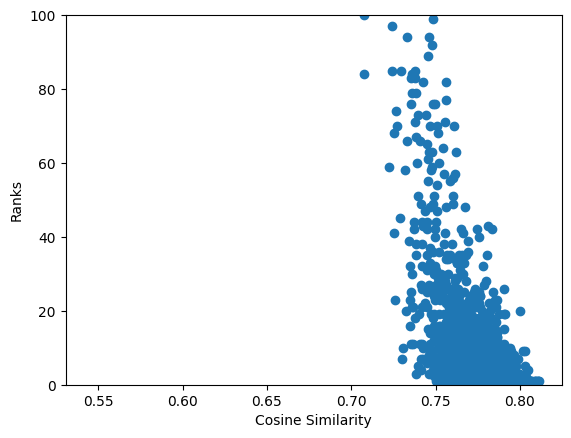

In [33]:
dir = "MLP_embeddings/embeddings/"
output_file = "output_file_mlp.png"

calculate_ranks_for_model(dir, output_file)

1000 test processed
2000 test processed
3000 test processed
Test Model:
Mean rank: 26.3850348379279
Hits at 1: 0.3477734019993941
Hits at 10: 0.8285368070281732
Hits at 100: 0.9712208421690397
Hits at 500: 0.9921235989094214
Hits at 1000: 0.9966676764616783
MRR: 0.5062697491739026



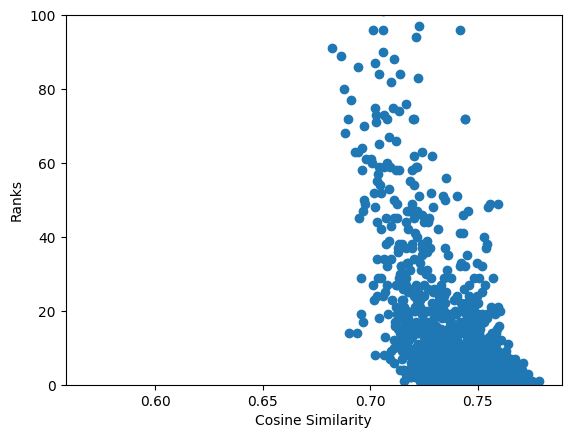

In [34]:
dir = "GCN_embeddings/embeddings/"
output_file = "output_file_gcn.png"

calculate_ranks_for_model(dir, output_file)

---


**Ensemble Results**

In [ ]:
# Ensemble output based on multiple embeddings.

# Modify the root dirs given below if needed.
'''
inputs = "../softmax_CLIP/embeddings"
dir1 = osp.join(inputs, "GCN1/")
dir2 = osp.join(inputs, "GCN2/")
dir3 = osp.join(inputs, "GCN3/")
dir4 = osp.join(inputs, "MLP1/")
dir5 = osp.join(inputs, "MLP2/")
dir6 = osp.join(inputs, "MLP3/")
dirs = [dir1, dir2, dir3, dir4, dir5, dir6]
'''

# Add the dirs where the output embeddings are stored

# MLP-Ensemble
# dirs = ['MLP_embeddings/embeddings', 'MLP2_embeddings/embeddings',
#        'MLP3_embeddings/embeddings']

# # GCN-Ensemble
# dirs = ['GCN_embeddings/embeddings', 'GCN2_embeddings/embeddings',
#         'GCN3_embeddings/embeddings']

# # All-Ensemble
dirs = ['MLP_embeddings/embeddings', 'GCN_embeddings/embeddings',
        'GCN2_embeddings/embeddings', 'MLP2_embeddings/embeddings',
        'GCN3_embeddings/embeddings', 'MLP3_embeddings/embeddings']

NUM_MODELS = len(dirs)

text_embeddings_train = []
text_embeddings_val = []
text_embeddings_test = []
chem_embeddings_train = []
chem_embeddings_val = []
chem_embeddings_test = []

cids_train = []
cids_val = []
cids_test = []

for i, dir in enumerate(dirs):
    cids_train.append(np.load(osp.join(dir, "cids_train.npy"), allow_pickle=True))
    cids_val.append(np.load(osp.join(dir, "cids_val.npy"), allow_pickle=True))
    cids_test.append(np.load(osp.join(dir, "cids_test.npy"), allow_pickle=True))

    text_embeddings_train.append(np.load(osp.join(dir, "text_embeddings_train.npy")))
    text_embeddings_val.append(np.load(osp.join(dir, "text_embeddings_val.npy")))
    text_embeddings_test.append(np.load(osp.join(dir, "text_embeddings_test.npy")))

    chem_embeddings_train.append(np.load(osp.join(dir, "chem_embeddings_train.npy")))
    chem_embeddings_val.append(np.load(osp.join(dir, "chem_embeddings_val.npy")))
    chem_embeddings_test.append(np.load(osp.join(dir, "chem_embeddings_test.npy")))

for i in range(1, NUM_MODELS):
    tmp = cids_train[i].tolist()
    indexes = [tmp.index(i) for i in cids_train[0]]
    tmp = cids_val[i].tolist()
    indexes_val = [tmp.index(i) for i in cids_val[0]]
    tmp = cids_test[i].tolist()
    indexes_test = [tmp.index(i) for i in cids_test[0]]

    cids_train[i] = cids_train[i][indexes]
    cids_val[i] = cids_val[i][indexes_val]
    cids_test[i] = cids_test[i][indexes_test]

    text_embeddings_train[i] = text_embeddings_train[i][indexes]
    text_embeddings_val[i] = text_embeddings_val[i][indexes_val]
    text_embeddings_test[i] = text_embeddings_test[i][indexes_test]

    chem_embeddings_train[i] = chem_embeddings_train[i][indexes]
    chem_embeddings_val[i] = chem_embeddings_val[i][indexes_val]
    chem_embeddings_test[i] = chem_embeddings_test[i][indexes_test]


all_text_embbedings = []
all_mol_embeddings = []
for i in range(NUM_MODELS):
    all_text_embbedings.append(np.concatenate((text_embeddings_train[i], text_embeddings_val[i], text_embeddings_test[i]), axis = 0))
    all_mol_embeddings.append(np.concatenate((chem_embeddings_train[i], chem_embeddings_val[i], chem_embeddings_test[i]), axis = 0))

all_cids = np.concatenate((cids_train[0], cids_val[0], cids_test[0]), axis = 0)

n_train = len(cids_train[0])
n_val = len(cids_val[0])
n_test = len(cids_test[0])
n = n_train + n_val + n_test

offset_val = n_train
offset_test = n_train + n_val

def memory_efficient_similarity_matrix_custom(func, embedding1, embedding2, chunk_size = 1000):
    rows = embedding1.shape[0]

    num_chunks = int(np.ceil(rows / chunk_size))

    for i in range(num_chunks):
        end_chunk = (i+1)*(chunk_size) if (i+1)*(chunk_size) < rows else rows
        yield func(embedding1[i*chunk_size:end_chunk,:], embedding2)

text_chem_cos = []
text_chem_cos_val = []
text_chem_cos_test = []
for i in range(NUM_MODELS):
    text_chem_cos.append(memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train[i], all_mol_embeddings[i]))
    text_chem_cos_val.append(memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val[i], all_mol_embeddings[i]))
    text_chem_cos_test.append(memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test[i], all_mol_embeddings[i]))

tr_avg_ranks = np.zeros((n_train, n))
val_avg_ranks = np.zeros((n_val, n))
test_avg_ranks = np.zeros((n_test, n))
ranks_train = []
ranks_val = []
ranks_test = []

def get_ranks_ensemble(text_chem_cos, ranks_avg, offset, split= ""):
    ranks_tmp = []
    j = 0 #keep track of all loops
    for l, emb in enumerate(text_chem_cos):
        for k in range(emb.shape[0]):
            cid_locs = np.argsort(emb[k,:], kind='stable')[::-1]
            ranks = np.argsort(cid_locs, kind='stable')

            ranks_avg[j,:] = ranks_avg[j,:] + ranks

            rank = ranks[j+offset] + 1
            ranks_tmp.append(rank)

            j += 1
            #if j % 1000 == 0: print(j, split+" processed")

    return np.array(ranks_tmp)

def print_ranks(ranks, model_num, split):

    print(split+" Model {}:".format(model_num))
    print("Mean rank:", np.mean(ranks))
    print("Hits at 1:", np.mean(ranks <= 1))
    print("Hits at 10:", np.mean(ranks <= 10))
    print("Hits at 100:", np.mean(ranks <= 100))
    print("Hits at 500:", np.mean(ranks <= 500))
    print("Hits at 1000:", np.mean(ranks <= 1000))

    print("MRR:", np.mean(1/ranks))
    print()

for i in range(NUM_MODELS):
  # For reduced time only do the test set
    if ENSEMBLE_FULL:
      ranks_tmp = get_ranks_ensemble(text_chem_cos[i], tr_avg_ranks, offset=0, split="train")
      print_ranks(ranks_tmp, i+1, split="Training")
      ranks_train.append(ranks_tmp)

      ranks_tmp = get_ranks_ensemble(text_chem_cos_val[i], val_avg_ranks, offset=offset_val, split="val")
      print_ranks(ranks_tmp, i+1, split="Validation")
      ranks_val.append(ranks_tmp)

    ranks_tmp = get_ranks_ensemble(text_chem_cos_test[i], test_avg_ranks, offset=offset_test, split="test")
    print_ranks(ranks_tmp, i+1, split="Test")
    ranks_test.append(ranks_tmp)

# Reduce the amount
if ENSEMBLE_FULL:
  sorted = np.argsort(tr_avg_ranks, kind='stable')
  new_tr_ranks = np.diag(np.argsort(sorted, kind='stable')) + 1
  print_ranks(new_tr_ranks, "e", split="Training Ensemble")

  sorted = np.argsort(val_avg_ranks, kind='stable')
  val_final_ranks = np.argsort(sorted, kind='stable') + 1
  new_val_ranks = np.diag(val_final_ranks[:,offset_val:offset_test])
  print_ranks(new_val_ranks, "e", split="Validation Ensemble")

sorted = np.argsort(test_avg_ranks, kind='stable')
test_final_ranks = np.argsort(sorted, kind='stable') + 1
new_test_ranks = np.diag(test_final_ranks[:,offset_test:])
print_ranks(new_test_ranks, "e", split="Test Ensemble")

Training Model 1:
Mean rank: 3.692403817025144
Hits at 1: 0.4215010602847622
Hits at 10: 0.9349439563768555
Hits at 100: 0.9999621326870646
Hits at 500: 1.0
Hits at 1000: 1.0
MRR: 0.5970124235836987

Validation Model 1:
Mean rank: 31.89639503180854
Hits at 1: 0.37291729778854893
Hits at 10: 0.8336867615873977
Hits at 100: 0.9669797031202666
Hits at 500: 0.9909118448954862
Hits at 1000: 0.9930324144198728
MRR: 0.5262182897953717

Test Model 1:
Mean rank: 23.88185398364132
Hits at 1: 0.38503483792790066
Hits at 10: 0.8439866707058468
Hits at 100: 0.9760678582247804
Hits at 500: 0.9933353529233565
Hits at 1000: 0.9966676764616783
MRR: 0.5375090497556491

Training Model 2:
Mean rank: 3.8116101181460165
Hits at 1: 0.426916086034535
Hits at 10: 0.9340351408664042
Hits at 100: 0.9992047864283551
Hits at 500: 1.0
Hits at 1000: 1.0
MRR: 0.5997735041480277

Validation Model 2:
Mean rank: 25.186610118146017
Hits at 1: 0.3462587094819752
Hits at 10: 0.8282338685246895
Hits at 100: 0.96667676461678

## Ablation Studies

We planned 5 ablation studies, but only completed 4 of them. The 5 ablations were:

1. Use BERT instead of SciBERT to gauge the impact.
1. Remove the learned temperature parameter from the general loss function to gauge the impact.
1. Remove negative sampling from the loss function for the cross-modal attention model to gauge the impact.
1. Use one token for each atom (r = 0) instead of two to gauge the impact.
1. Remove layer normalization from the encoders to gauge the impact.

We did not complete ablation 4, using one token for each atom. This would have required us to work on mol2vec rather than text2mol which was too much additional work for us to complete in a timely fashion.

Code for each of the ablations resides in a separate notebook on GitHub checked into our [repository](https://github.com/mgdixon/text2mol-team29/tree/main):

* [MLP](https://github.com/mgdixon/text2mol-team29/blob/main/MLP_Ablation.ipynb)
* [GCN](https://github.com/mgdixon/text2mol-team29/blob/main/GCN_Ablation.ipynb)
* [Attention](https://github.com/mgdixon/text2mol-team29/blob/main/attention_model_Ablation.ipynb)

Each file uses a similar format with some binary globals defined to pick the ablation being run.

---

### Ablation 1

Ablation 1 swaps the use of the SciBERT text model for a standard BERT model from Google. Specifically, the code changes are:

```
if self.ablation_1:
  self.text_tokenizer = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased")
else:
  self.text_tokenizer = BertTokenizerFast.from_pretrained('allenai/scibert_scivocab_uncased')
```

This swaps the `allenai/scibert_scivocab_uncased` model for the standard `google-bert/bert-base-uncased` which comes from the original BERT paper and was released by Google.

This swap was done for all three models: MLP, GCN and Attention.

#### **Results for Ablation 1**

Below are the results of Ablation 1 on the MLP model. It is a marginal decrease in accuracy from the earlier model which had an **MRR of 0.604.**

| Metric | Training | Test |
|---|---|---|
| Training Mean rank | 3.78601 | 24.7337 |
| Hits at 1 | 0.422448 | 0.327174 |
| Hits at 10 | 0.931839 | 0.813996 |
| Hits at 100 | 0.999886 | 0.973341 |
| Hits at 500 | 1.000000 | 0.992124 |
| Hits at 1000 | 1.000000 | 0.996668 |
| Trainng MRR | 0.594295 | 0.485878 |

On the GCN model the results are:

| Metric | Training | Test |
|---|---|---|
| Training Mean rank | 4.146736 | 33.787337 |
| Hits at 1 | 0.397683 | 0.282339 |
| Hits at 10 | 0.915897 | 0.777340 |
| Hits at 100 | 0.999508 | 0.963042 |
| Hits at 500 | 1.000000 | 0.988488 |
| Hits at 1000 | 1.000000 | 0.992729 |
| Training MRR | 0.572543 | 0.443452 |

---

### Ablation 2

Ablation 2 removes the learned temperature parameter of `0.07` from the model:

```
if not self.ablation_2:
  self.temp = nn.Parameter(torch.Tensor([0.07]))
  self.register_parameter( 'temp' , self.temp )
```

In the forward pass of the model, the code is also changed to have:

```
if not self.ablation_2:
  x = x * torch.exp(self.temp)
  text_x = text_x * torch.exp(self.temp)
```

The overall impact of ablation 2 was a minor loss in validation accuracy of the MLP and GCN models.

#### **Results for Ablation 2**

| Metric | MLP Training | MLP Test | GCN Training | GCN Test |
|---|---|---|---|---|
| Training Mean rank | 3.619434 | 24.420782 | 3.750530 | 23.648288 |
| Hits at 1 | 0.432823 | 0.338079 | 0.428696 | 0.334747|
| Hits at 10 | 0.938125 | 0.822781 | 0.933278 | 0.826719 |
| Hits at 100 | 0.999962 | 0.975462 | 0.999394 | 0.976674 |
| Hits at 500 | 1.0 | 0.994850 | 1.0 | 0.993032 |
| Hits at 1000 | 1.0 | 0.996062 | 1.0 | 0.996668 |
| Training MRR | 0.604722 | 0.498676 | 0.600432 | 0.494759 |

---

### Ablation 3

Ablation 3 removes negative sampling from the loss function for the cross-modal attention model to gauge the impact.

The data generator function for the model was changed for ablation 3. It was previously using a coin toss to pick between a positive and negative sample. Setting `ablation_3 == True` we now force it to only pick positive examples.

```
if self.ablation_3 or label:
  text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, max_length=self.text_trunc_length - 1,
                                  padding='max_length', return_tensors = 'np')
else:
  text_input = self.text_tokenizer(self.descriptions[rand_cid], truncation=True, max_length=self.text_trunc_length - 1,
                                   padding='max_length', return_tensors = 'np')

```

Additionally, the loss function needs to be changed. Instead of using the binary cross entropy with logits, we switch back to the original cross entropy loss.

```
criterion = nn.BCEWithLogitsLoss()

def loss_func(v1, v2, labels):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  eye = torch.diag_embed(labels).to(device)
  return criterion(logits, eye) + criterion(torch.transpose(logits, 0, 1), eye), logits.diag() > 0

CE = nn.CrossEntropyLoss()

def loss_func_CE(v1, v2, labels_unused):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0]).to(device)
  return CE(logits, labels) + CE(torch.transpose(logits, 0, 1), labels)
```

Ablation 3 seemed to make a small difference in the validatio loss of the final model.

Validation losses for the ablation versus the paper:

| Base Model | Ablation 3 |
| - | - |
| 0.007 | 0.003 |

Overall the ablation makes little difference in the results of the association rules. The results are within the normal range of initialization variables.

| Metric | Baseline | Ablation |
|---|---|---|
| Val Mean rank | 30.2 | 30.1 |
| Hits at 1 | 0.085 | 0.106 |
| Hits at 10 | 0.832 | 0.832 |
| Hits at 100 | 0.969 | 0.969 |
| Validation MRR | 0.263 | 0.278 |


---

### Ablation 4

We specified ablation 4 to use one token for each atom `(r = 0)` instead of two to gauge the impact. The dataset we have gives us the mol2vec of the molecule already. mol2vec uses Morgan fingerprinting to convert from atoms to tokens and then convert the sentences of tokens to atom embeddings, which are then averaged to create the molecule embeddings. After discussing as a team, we decided that doing ablation 4 required both code and knowledge we did not have.

---

### Ablation 5

Ablation 5 removes layer normalization from the encoders to gauge the impact.

In the model we have the following code:
```
if not self.ablation_5:
  self.ln1 = nn.LayerNorm((nout))
  self.ln2 = nn.LayerNorm((nout))
```

And in the forward pass:
```
if not self.ablation_5:
  x = self.ln1(x)
  text_x = self.ln2(text_x)
```

Ablation 5 had a major impact on validation loss. On GCN for example, the loss went from `0.14` to `0.52`. On MLP the losses also went up from `0.14` to `0.26`.

#### **Results of Ablation 5**

As shown in the validation loss above, Ablation 5 had a major impact on training. While the impact on the MLP was significant, the impact on GCN was substantial. It decreased the mean rank substantially, and made the hits go down significantly.

| Metric | MLP Training | MLP Test | GCN Training | GCN Test |
|---|---|---|---|---|
| Training Mean rank | 8.648023 | 36.293850 | 139.584785 | 232.534384 |
| Hits at 1 | 0.199636 | 0.169040 | 0.012269 | 0.008785 |
| Hits at 10 | 0.758217 | 0.665859 | 0.115268 | 0.100576 |
| Hits at 100 | 0.997842 | 0.963950 | 0.640336 | 0.561042 |
| Hits at 500 | 1.000000 | 0.988488 | 0.944335 | 0.887913 |
| Hits at 1000 | 1.000000 | 0.994850 | 0.984437 | 0.956983 |
| Training MRR | 0.370901 | 0.319430 | 0.053299 | 0.046065 |

---

# Discussion

## Implications

Our results outperform the models given in the paper. We have no explanation for this. While some changes, such as the SciBERT model evolving, might yield superior results, we do not have a hypothesis on why our training appeared to have a much higher MRR. Our only thesis is that something underlying in PyTorch may have changed. We discussed our findings with two other teams who also looked into this paper. All three teams encountered similar results with completely independent implementations. This cannot be a coincidence.

Our ablations show that the original model is better than any of the alternatives. While the SciBERT model has evolved since the author's ran their model, based upon our ablation study we do not believe this to be material enough to cause the shift in results.

## Reproduction

The code in the paper was reproducible although we had great difficulty with one portion (extracting the multi-head attention). There are aspects of the paper (specifically calling out MLP1, 2, 3 and GCN1, 2, 3) that are quite confusing. In particular, MLP1/2/3 differ based upon initialization, but that is not clearly stated in the code or the paper.


## What was easy?

* The authors made it easy with both Python and Jupyter notebooks.
* While the dataset was mislabeled in the GitHub repository, it was fully available.
* The paper and the subject are approachable.

## What was difficult?

* There are few instances of duplicated code, and the minor differences that existed between the duplicated code, did not have clear explanations.
* One particular section of code which was responsible for extracting the multi-head attention weights relied upon an older form of PyTorch. Most likely this might have been a non-issue when the original authors implemented the code.
* In some cases, it was difficult for us to understand what the authors intended due to lack of comments.
* When initially reproducing, it was quite difficult for multiple members to reproduce the code and notebooks locally (on our individual computers / laptops). We ran into a plethora of different errors, most of which took a long time to debug. Eventually due to shortage of time, we abandoned the local reproduction and switched to setting up and using a Google Collab notebook since the final submission would require that anyway. Once moving to the Collab notebook and switching the runtime to use a GPU, most of the original code started to work seamlessly.

## Suggestions to the authors

* Some of the code can be refactored so it can help aid in better understanding.
* Performance profiling might be beneficial in certain areas of the code. These may help improve performance from a range of 10% to 3x. For example, a minor tweak to the loss calculation by keeping the values on the GPU helps decrease step time by 10%
* It would really help readers if the paper went into more detail on the MLP1, MLP2, MLP3 and GCN1, GCN2, GCN3.
* As mentioned in the above section, reproduction of the code could be difficult based on a few scenarios. It would be beneficial if the authors included a section on the best way to reproduce the code, for example use a Google collab notebook, reproducing locally is not preferred, use these particular versions etc.


# References

1. Edwards, Carl & Zhai, ChengXiang & Ji, Heng. (2021). Text2Mol: Cross-Modal Molecule Retrieval with Natural Language Queries. 595-607. 10.18653/v1/2021.emnlp-main.47.

1. Beltagy, I., Lo, K., & Cohan, A. (2019). SciBERT: A Pretrained Language Model for Scientific Text. Conference on Empirical Methods in Natural Language Processing.

1. Jaeger, Sabrina and Fulle, Simone and Turk, Samo. (2018) Mol2vec: Unsupervised Machine Learning Approach with Chemical Intuition. Journal of Chemical Information and Modeling 10.1021/acs.jcim.7b00616

1. Chemical Entities of Biological Interest (ChEBI) https://www.ebi.ac.uk/chebi/downloadsForward.do

1. GitHub Text2Mol repository: https://github.com/cnedwards/text2mol

1. Liang Zhang and Xiaobing Zhao. (2020). An overview of cross-language information retrieval. In International Conference on Artificial Intelligence and Security, pages 26–37. Springer.

1. Ivan Vulic and Marie-Francine Moens. (2015). Monolingual and cross-lingual information retrieval models based on (bilingual) word embeddings. In Proceed- ings of the 38th International ACM SIGIR Conference on Research and Development in Information Retrieval, Santiago, Chile, August 9-13, 2015, pages 363–372. ACM.

1. Paheli Bhattacharya, Pawan Goyal, and Sudeshna Sarkar. (2016). Using word embeddings for query translation for hindi to english cross language information retrieval. Computación y Sistemas, 20(3):435–447.

1. Janna Hastings, Gareth Owen, Adriano Dekker, Marcus Ennis, Namrata Kale, Venkatesh Muthukrishnan, Steve Turner, Neil Swainston, Pedro Mendes, and Christoph Steinbeck. 2016. Chebi in 2016: Improved services and an expanding collection of metabolites. Nucleic acids research,44(D1):D1214–D1219.

1. Sunghwan Kim, Paul A. Thiessen, Evan E. Bolton, Jie Chen, Gang Fu, Asta Gindulyte, Lianyi Han, Jane He, Siqian He, Benjamin A. Shoemaker, et al. 2016. Pubchem substance and compound databases. Nucleic acids research, 44(D1):D1202–D1213.
